In [21]:

import DW_oscillator as DW
import numpy as np
from IPython.display import clear_output

from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

"run_field_sequence" that randomly generates and simulates a set of fields. It returns the time, DW position and angle plus the input time sequence.
field_low and field_high specify the range the fields will be generated over while N_fields is the number of fields in the sequence and T is the time period of each field.

The outputs of interest are t, y and h_t. y[0] is the DW position over time (at time points given in t) and h_t is the magnetic field (serves as input) at the same times.

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [23]:
np.random.seed(7)
torch.manual_seed(7)

In [24]:
t, y, h_t, fields, periods = DW.run_field_sequence(field_low = 0, field_high = 500.0, N_fields = 50, T = 6,y0 = [0.0,0.0])

[203.03267116 237.00582487 124.72262154 163.85957951 359.9387291
 255.19172843 444.57974565 157.83660927   4.56059836 204.46766516
 264.88780181  49.27690507 204.32993537 435.23601089  11.38667583
 323.80375881  44.46742025  52.69685408 277.52326427 139.98938479
  65.12863552 398.95724367 194.90522807 284.25792178 243.148487
 429.29568446  31.10300118  76.31935448 113.67701821 252.60754472
 303.48842831 201.35869899 108.36458217  47.40414468 344.76087495
 491.6348517  273.25886067 132.49743865 295.50883615 495.53347801
 356.49192556 205.69858695 105.01231756 379.69406454 285.91853978
 110.44736143 123.64595851  70.73809123 273.20896115 479.80659983]
[6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6.]


In [25]:
t.shape,y.shape,h_t.shape,fields.shape,periods.shape

((3000,), (2, 3000), (3000,), (50,), (50,))

In [26]:
fields,periods

(array([203.03267116, 237.00582487, 124.72262154, 163.85957951,
        359.9387291 , 255.19172843, 444.57974565, 157.83660927,
          4.56059836, 204.46766516, 264.88780181,  49.27690507,
        204.32993537, 435.23601089,  11.38667583, 323.80375881,
         44.46742025,  52.69685408, 277.52326427, 139.98938479,
         65.12863552, 398.95724367, 194.90522807, 284.25792178,
        243.148487  , 429.29568446,  31.10300118,  76.31935448,
        113.67701821, 252.60754472, 303.48842831, 201.35869899,
        108.36458217,  47.40414468, 344.76087495, 491.6348517 ,
        273.25886067, 132.49743865, 295.50883615, 495.53347801,
        356.49192556, 205.69858695, 105.01231756, 379.69406454,
        285.91853978, 110.44736143, 123.64595851,  70.73809123,
        273.20896115, 479.80659983]),
 array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6.

In [27]:
flag = False

In [28]:
#h_t_ = torch.div(torch.tensor(h_t, dtype=torch.float64),1000.).to(device)  # Converting to column vector
y_0_ = torch.tensor(y[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data = torch.stack((torch.div(y_0_, 1000.),y_1_)).to(device)  # Converting to column vector

In [29]:
train = data[:,:].transpose(0,1).to(device)

In [30]:
time_train = torch.tensor(t).to(device)

In [31]:
def get_batch(true_y,time, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    batch_y0 = true_y[indices]  # (batch_size, D)
    batch_t = time[:batch_size]  # (batch_size)
    batch_y = torch.stack([true_y[indices + i] for i in range(batch_size)], dim=0)  # (batch_size, M, D)
    indices = torch.tensor(indices)
    return batch_y0,batch_t,batch_y,indices

In [32]:
class sequence:
    """
    Callable class to produce a time-dependent field sequence using PyTorch tensors.
    """
    def __init__(self, fields, periods):
        self.fields = torch.tensor(fields, dtype=torch.float64).to(device)
        self.periods = torch.tensor(periods, dtype=torch.float64).to(device)
        self.periods_sum = torch.cumsum(self.periods, dim=0)

    def __call__(self, t):
        if t < 0.0:
            val = torch.tensor(0.0, dtype=torch.float64)
        elif t >= self.periods_sum[-1]:
            val = torch.tensor(0.0, dtype=torch.float64)
        else:
            t_diff = self.periods_sum - t
            n = 0
            for i in range(len(t_diff)):
                if t_diff[i] >= 0.0:
                    n = i 
                    break
            #n = torch.argmax(t_diff >= 0.0)  # Find the first index where t_diff >= 0.0
            val = self.fields[n]
        return val

In [33]:
h_time = sequence(fields,periods)

In [34]:
class DWODE(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self, h_time, frequency ):
        super(DWODE, self).__init__()
        self.lin = nn.Linear(3, 128)
        self.lin2 = nn.Linear(128, 256)
        self.lin3 = nn.Linear(256,512)
        self.lin4 = nn.Linear(512,1024)
        self.lin5 = nn.Linear(1024,2)
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU()
        self.h_time = h_time #  function to return the field magnitude at time t
        self.omega = 2*torch.pi * frequency # store the angular frequency for calculating field
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU()
        self.nfe = 0

    def forward(self,t,x):
        self.nfe += 1
        if flag == False:
            h_accumulator = torch.zeros_like(intervals, dtype=torch.float64)
            for i,j in enumerate(intervals):
            
                h = self.h_time(j) * torch.sin(self.omega*j )
                h_accumulator[i] = h
            h = torch.div(h_accumulator,1000.).unsqueeze(1)
        else : 
            h = self.h_time(t) * torch.sin(self.omega*t)
            h = torch.div(h,1000.).unsqueeze(0).unsqueeze(0)
        x_aug = torch.cat([x, h], 1)
        x = self.lrelu(self.lin(x_aug))
        x = self.lrelu(self.lin2(x))
        x = self.lrelu(self.lin3(x))
        x = self.tanh(self.lin4(x))
        x = self.lin5(x)
        return x
     

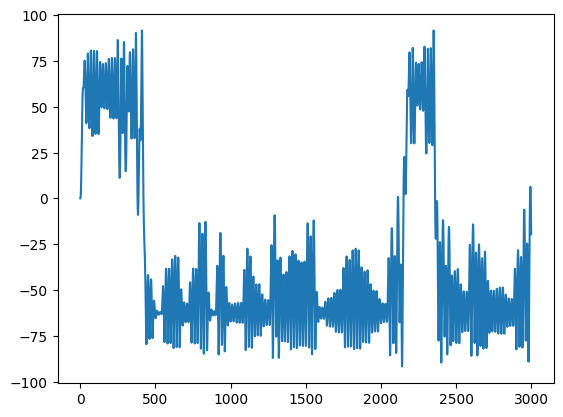

In [35]:
plt.plot(y[0])

In [36]:
model = DWODE(h_time,frequency=0.5).double().to(device)

In [37]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [38]:
# def app (indices):
#     omega = torch.tensor(2 * torch.pi * 0.5)  # f = 0.5
#     if flag == True:
#         h_accumulator = torch.zeros_like(torch.tensor([0.]), dtype=torch.float64)  # Initialize an empty tensor for h
#         omega = omega * time_train[0]
#         h = h_t_[0] * torch.sin(omega)
#         h_accumulator = h
#         return h_accumulator.unsqueeze(0)
#     h_accumulator = torch.zeros_like(indices, dtype=torch.float64)  # Initialize an empty tensor for h
    
#     for i in range(len(indices)):
#         omega = omega * time_train[indices[i]]  # Assuming t is defined elsewhere
#         h = h_t_[indices[i]] * torch.sin(omega)  # Assuming h_t is defined elsewhere
#         h_accumulator[i] = h  # Store the calculated h in the accumulator tensor
    
#     return h_accumulator.unsqueeze(0)  # Return the accumulator tensor
        

In [39]:
from torchdiffeq import odeint_adjoint as adjoint

In [40]:
losses = []
whole_losses = []
best_loss = 100.0
batch_size = 8
for i in range(3000):

    optimizer.zero_grad()
    
    init,batch_t,truth,indices = get_batch(train,time_train,batch_size)
    intervals = time_train[indices]
    #print(init,batch_t,truth)
    pred_y = adjoint(model,init,batch_t,method='dopri5')
    loss = F.huber_loss(pred_y, truth)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model.state_dict(), 'saved_models/multiple_forward_field_3_bigdata.pth')
    if i >= 1000:
        batch_size = 16
    if i >= 2000:
        batch_size = 32
    if i % 100 == 0:
    
        with torch.no_grad():
            flag = True
            intervals = time_train
            pred_y = adjoint(model, train[0].view(1,-1), time_train,method='dopri5')
            pred_y = pred_y.squeeze(1)
            loss = F.huber_loss(pred_y, train)
            whole_losses.append(loss.item())
            flag = False
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            x_pred = pred_y[:,0].cpu()
            y_pred = pred_y[:,1].cpu()
            

            # Extract the x, y, z coordinates from X_train_plt
            x_train = train[:,0].cpu()
            y_train = train[:,1].cpu()
            

            fig, ax = plt.subplots(2, 1, figsize=(8, 8))
            ax[0].plot(x_train, label='True')
            ax[0].plot(x_pred, label='Predicted', linestyle='--')
            ax[0].set_ylabel('Y_0')
            ax[0].set_title('Projection')
            ax[0].legend()

            ax[1].plot(y_train, label='True')
            ax[1].plot(y_pred, label='Predicted',linestyle='--')
            ax[1].set_ylabel('Y_1')
            ax[1].set_title('Projection')
            ax[1].legend()


            plt.tight_layout()
            plt.show()
            clear_output(wait=True)

KeyboardInterrupt: 

In [41]:
print(best_loss)

2.2158951071963054e-06


In [42]:
test_model = DWODE(h_time,0.5).double().to(device)

In [43]:
test_model.load_state_dict(torch.load('saved_models/multiple_forward_field_3_bigdata.pth'))

<All keys matched successfully>

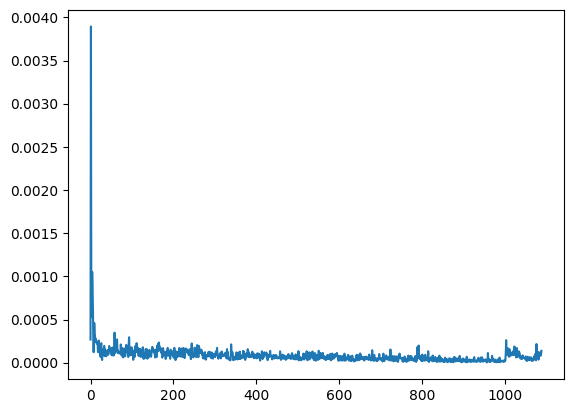

In [44]:
plt.plot(losses)
plt.show()

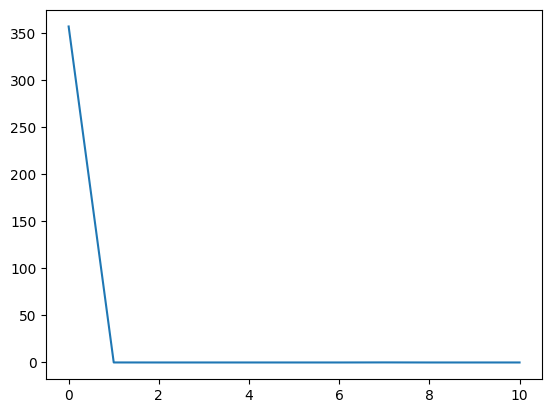

In [45]:
plt.plot(whole_losses)

plt.show()

In [46]:
with torch.no_grad():
    flag = True
    intervals = time_train
    pred = adjoint(test_model, train[0].view(1,-1), time_train,method='dopri5')
    flag = False

In [47]:
pred = pred.cpu().detach().numpy()

In [48]:
pred = pred.squeeze(1)

In [49]:
pred.shape,train.shape

((3000, 2), torch.Size([3000, 2]))

In [50]:
data = data.transpose(0,1)

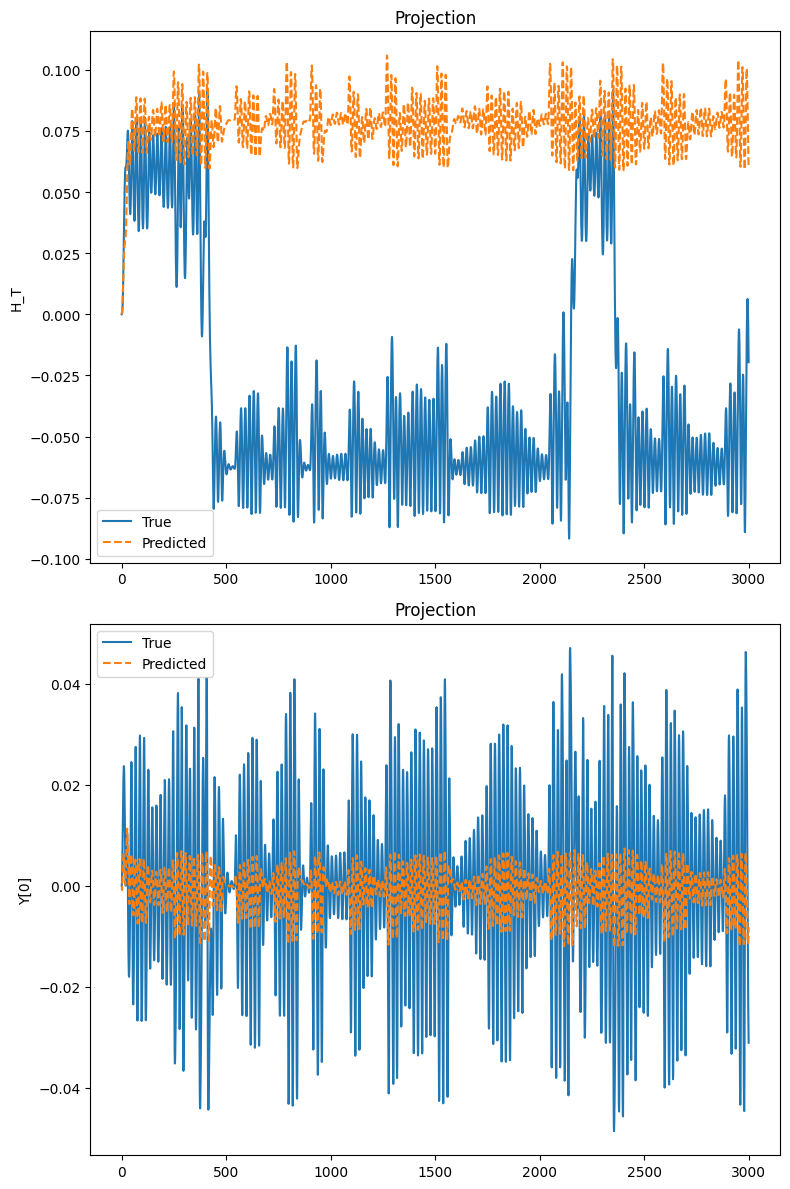

In [51]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,0]
y_pred = pred[:,1]


# Extract the x, y, z coordinates from X_train_plt
x_train = train[:,0].cpu()
y_train = train[:,1].cpu()

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('H_T')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[0]')
ax[1].set_title('Projection')

ax[1].legend()
plt.savefig('multiple_forward_field_3_bigdata.png')
plt.tight_layout()
plt.show()

In [52]:
t_, y_, ht, fields_, periods_ = DW.run_field_sequence(field_low = 0, field_high = 500.0, N_fields = 10, T = 10,y0 = [0.0,0.0])

[359.87206973 231.43970076 201.11932028 392.74281153 109.92906069
 121.29710267 118.62550476 121.96977346 263.73399969 268.3771783 ]
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


In [53]:
h_t_ = torch.div(torch.tensor(ht, dtype=torch.float64),1000.).to(device)  # Converting to column vector
y_0_ = torch.tensor(y_[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y_[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data_ = torch.stack((torch.div(y_0_, 1000.),y_1_)).to(device)  # Converting to column vector

In [54]:
test_train = torch.tensor(t_).to(device)

In [55]:
test = data_[:,:].transpose(0,1).to(device)

In [56]:
h_time = sequence(fields_,periods_)

In [57]:
test_model = DWODE(h_time,frequency=0.5).double().to(device)

In [58]:
test_model.load_state_dict(torch.load('saved_models/multiple_forward_field_3_bigdata.pth'))

<All keys matched successfully>

In [59]:
with torch.no_grad():
    flag = True
    intervals = test_train
    pred = adjoint(test_model, test[0].view(1,-1), test_train,method='dopri5')
    flag = False

In [60]:
pred = pred.cpu().detach().numpy()

In [61]:
pred = pred.squeeze(1)

In [ ]:
data_ = data_.transpose(0,1)

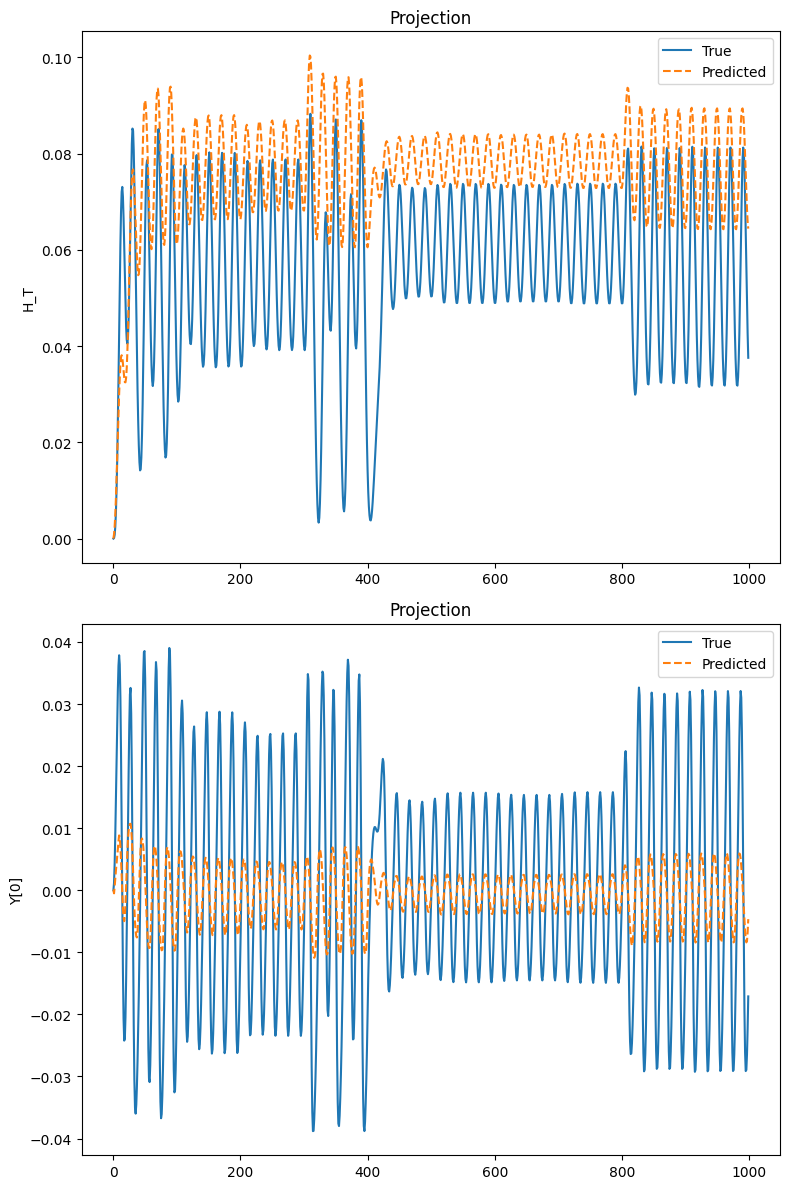

In [62]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,0]
y_pred = pred[:,1]


# Extract the x, y, z coordinates from X_train_plt
x_train = test[:,0].cpu()
y_train = test[:,1].cpu()

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('H_T')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[0]')
ax[1].set_title('Projection')

ax[1].legend()
plt.savefig('multiple_forward_field_test_data_bigdata.png')
plt.tight_layout()
plt.show()